In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Pre processing

#### Đọc data vào từ folder

In [ ]:
def load_images_and_labels(df, root_path, target_size=(224,224)):
    images = []
    labels = []

    if not root_path.endswith('/'):
        root_path += '/'

    for idx, row in df.iterrows():
        image_path = os.path.join(root_path, row['crop_face_file_path'])

        print(f"Processing image {idx + 1}: {image_path}")

        # Check if image exists
        if not os.path.exists(image_path):
            print(f"Warning: Image {image_path} not found.")
            continue

        image = cv2.imread(image_path)

        # If image couldn't be loaded, skip it
        if image is None:
            print(f"Warning: Failed to load image {image_path}.")
            continue

        image = cv2.resize(image, target_size)  # Resize image to a standard size (224x224)

        images.append(image)

        # Convert multi-label to a list
        label = [row['natural'], row['sleepy_eye'], row['yawn'], row['rub_eye'], row['look_away']]
        labels.append(label)

    images = np.array(images, dtype=np.float32) # Chuyển sang float để chuẩn hóa sau
    labels = np.array(labels)
    return images, labels

In [ ]:
# Path to CSV file (adjust to your machine's path)
csv_path = r'/content/drive/MyDrive/ComputerVision/dataset_multi_label/training_data.csv'
df = pd.read_csv(csv_path)

In [ ]:
print(df.head())
print(f'Số mẫu: {df.shape[0]}')
print(f'Số cột: {df.shape[1]}')

               original_file_path                    crop_face_file_path  \
0  images/20250307_222829_001.jpg  cropped_faces/20250307_222829_001.jpg   
1  images/20250307_222829_002.jpg  cropped_faces/20250307_222829_002.jpg   
2  images/20250307_222829_003.jpg  cropped_faces/20250307_222829_003.jpg   
3  images/20250307_222829_004.jpg  cropped_faces/20250307_222829_004.jpg   
4  images/20250307_222829_005.jpg  cropped_faces/20250307_222829_005.jpg   

       labels  natural  sleepy_eye  yawn  rub_eye  look_away  
0     natural        1           0     0        0          0  
1     natural        1           0     0        0          0  
2     natural        1           0     0        0          0  
3  sleepy_eye        0           1     0        0          0  
4  sleepy_eye        0           1     0        0          0  
Số mẫu: 3436
Số cột: 8


#### Đọc image, labels vào từ folder (chỉ load lần đầu khi chưa save images, labels)

In [ ]:
root_path = '/content/drive/MyDrive/ComputerVision/dataset_multi_label/'
images, labels = load_images_and_labels(df, root_path)

Processing image 1: /content/drive/MyDrive/ComputerVision/dataset_multi_label/cropped_faces/20250307_222829_001.jpg
Processing image 2: /content/drive/MyDrive/ComputerVision/dataset_multi_label/cropped_faces/20250307_222829_002.jpg
Processing image 3: /content/drive/MyDrive/ComputerVision/dataset_multi_label/cropped_faces/20250307_222829_003.jpg
Processing image 4: /content/drive/MyDrive/ComputerVision/dataset_multi_label/cropped_faces/20250307_222829_004.jpg
Processing image 5: /content/drive/MyDrive/ComputerVision/dataset_multi_label/cropped_faces/20250307_222829_005.jpg
Processing image 6: /content/drive/MyDrive/ComputerVision/dataset_multi_label/cropped_faces/20250307_222829_006.jpg
Processing image 7: /content/drive/MyDrive/ComputerVision/dataset_multi_label/cropped_faces/20250307_222829_007.jpg
Processing image 8: /content/drive/MyDrive/ComputerVision/dataset_multi_label/cropped_faces/20250307_222829_008.jpg
Processing image 9: /content/drive/MyDrive/ComputerVision/dataset_multi_

In [ ]:
np.save('images.npy', images)
np.save('labels.npy', labels)

#### Load image and label

In [3]:
images = np.load('./data/images.npy')
labels = np.load('./data/labels.npy')

#### Data augmentation

In [4]:
# Data Augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescaling images to range [0, 1]
    rotation_range=15,  # Random rotation between -15 and 15 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill mode for empty pixels after transformation
)

# Data Augmentation for validation images (usually, we don't augment validation data)
val_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

#### Apply the augmentation to the data

In [6]:
# Lưu ý: ImageDataGenerator.flow() nhận đầu vào là dữ liệu numpy
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

### Build the CNN Model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_custom_cnn(input_shape=(224, 224, 3), num_classes=5):
    """Xây dựng một mô hình CNN tùy chỉnh đơn giản."""
    model = Sequential(name='Custom_CNN') # Đặt tên cho model

    # Input Layer (tùy chọn nhưng rõ ràng hơn)
    model.add(Input(shape=input_shape))

    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization()) # Giúp ổn định và tăng tốc training
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 4 (Có thể thêm hoặc bớt tùy độ phức tạp mong muốn)
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening
    model.add(Flatten())

    # Dense Head
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) # Dropout để giảm overfitting

    # Output Layer
    model.add(Dense(num_classes, activation='sigmoid')) # Sigmoid cho multi-label

    return model

# Tạo instance của model custom
model_custom = build_custom_cnn(input_shape=(224, 224, 3), num_classes=5)

# Compile model custom
# Có thể thử learning rate cao hơn một chút so với fine-tuning MobileNet ban đầu
initial_learning_rate_custom = 1e-3
optimizer_custom = Adam(learning_rate=initial_learning_rate_custom)

model_custom.compile(optimizer=optimizer_custom,
                     loss='binary_crossentropy',
                     metrics=['accuracy']) # 'accuracy' ở đây là binary accuracy

print("--- Custom CNN Summary ---")
model_custom.summary()

--- Custom CNN Summary ---
Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                             

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt

# --- Callbacks cho Custom CNN ---
# Đặt tên file checkpoint khác đi
checkpoint_callback_custom = ModelCheckpoint(
    './new_models/custom_cnn_checkpoint.weights.h5', # Tên file khác
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True, # Chỉ lưu weights để tiết kiệm dung lượng
    mode='min',
    verbose=1
)

# EarlyStopping và ReduceLROnPlateau có thể giữ nguyên hoặc điều chỉnh patience
early_stopping_custom = EarlyStopping(monitor='val_loss', patience=15, # Có thể cần patience cao hơn cho custom model
                                   restore_best_weights=True, verbose=1)
reduce_lr_custom = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6, verbose=1)

# --- Huấn luyện ---
epochs_custom = 50 # Custom model thường cần nhiều epochs hơn để học từ đầu
batch_size_custom = 32 # Giữ nguyên batch size

print("\n--- Training Custom CNN ---")

# Đảm bảo các generator được reset nếu bạn chạy lại cell này trong notebook
# train_generator.reset()
# val_generator.reset()

history_custom = model_custom.fit(
    train_generator,
    epochs=epochs_custom,
    validation_data=val_generator,
    callbacks=[checkpoint_callback_custom, early_stopping_custom, reduce_lr_custom]
)

# --- Lưu model cuối cùng (sau khi EarlyStopping đã restore best weights) ---
print("Saving final custom CNN model...")
model_custom.save('./new_models/custom_cnn_sleepiness_model.h5') # Lưu model với tên khác
print("Custom CNN model saved to custom_cnn_sleepiness_model.h5")

In [ ]:
# --- Vẽ biểu đồ loss cho Custom CNN ---
if 'history_custom' in locals() and hasattr(history_custom, 'history'):
    if 'loss' in history_custom.history and 'val_loss' in history_custom.history:
        train_loss_custom = history_custom.history['loss']
        val_loss_custom = history_custom.history['val_loss']
        epochs_range_custom = range(1, len(train_loss_custom) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(epochs_range_custom, train_loss_custom, label='Custom CNN Training Loss')
        plt.plot(epochs_range_custom, val_loss_custom, label='Custom CNN Validation Loss')
        plt.title('Custom CNN Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Lỗi: Đối tượng 'history_custom' không chứa 'loss' hoặc 'val_loss'.")
else:
    print("Lỗi: Đối tượng 'history_custom' chưa được tạo.")

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, multilabel_confusion_matrix
# Hàm plot_multilabel_confusion_matrices đã định nghĩa ở câu trả lời trước

# --- Load Model Custom Tốt Nhất (nếu cần, EarlyStopping đã làm) ---
# model_custom.load_weights('custom_cnn_checkpoint.weights.h5') # Nếu chỉ lưu weights
# Hoặc load model đã lưu đầy đủ:
# from tensorflow.keras.models import load_model
# model_custom = load_model('custom_cnn_sleepiness_model.h5')

print("\n--- Evaluating Custom CNN Model ---")

# --- Chuẩn bị dữ liệu validation (giống hệt MobileNet) ---
X_val_processed = X_val.astype('float32') / 255.0
y_val_true = y_val

# --- Lấy dự đoán từ Custom CNN ---
print("Lấy dự đoán từ Custom CNN trên tập validation...")
y_pred_proba_custom = model_custom.predict(X_val_processed)

# --- Chuyển đổi dự đoán thành Binary (dùng cùng threshold) ---
threshold = 0.5
print(f"Áp dụng ngưỡng threshold = {threshold}...")
y_pred_binary_custom = (y_pred_proba_custom >= threshold).astype(int)

# --- Đánh giá bằng model.evaluate (sử dụng generator) ---
print("Đánh giá bằng model.evaluate()...")
loss_custom, accuracy_custom = model_custom.evaluate(val_generator) # Dùng generator!
print(f"Custom CNN Validation Loss (from evaluate): {loss_custom:.4f}")
print(f"Custom CNN Validation Accuracy (binary, from evaluate): {accuracy_custom:.4f}")


# --- In Classification Report ---
print("\n--- Classification Report (Custom CNN - Validation Set) ---")
report_custom = classification_report(
    y_val_true,
    y_pred_binary_custom,
    target_names=class_labels, # class_labels đã định nghĩa trước đó
    zero_division=0
)
print(report_custom)

# --- Vẽ Confusion Matrices ---
print("\n--- Vẽ Confusion Matrices (Custom CNN - Validation Set) ---")
# Giả sử hàm plot_multilabel_confusion_matrices đã có
plot_multilabel_confusion_matrices(y_val_true, y_pred_binary_custom, class_labels)

### MobileNetV2

In [8]:
from tensorflow.keras.applications import MobileNetV2 # Hoặc EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=5):
    # Load pre-trained base model (không bao gồm lớp fully connected cuối)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Đóng băng các lớp của base model (để không huấn luyện lại chúng ban đầu)
    base_model.trainable = False # Quan trọng!

    x = base_model.output
    x = GlobalAveragePooling2D()(x) # Giảm chiều dữ liệu
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x) # Sử dụng sigmoid cho multi-label

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

mobilnetv2_model = build_mobilenetv2_model()
mobilnetv2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

#### Training MobileNetV2

In [10]:
# import earlystopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [12]:
# --- Callbacks (as before) ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
# Make sure checkpoint saves best weights from this phase
checkpoint_callback_head = ModelCheckpoint(
    './new_models/model_head_checkpoint.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("--- Training Head ---")
initial_epochs = 20 # Increase initial epochs

history_head = mobilnetv2_model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator,
    callbacks=[checkpoint_callback_head, early_stopping, reduce_lr]
)

# Load the best weights from head training
print("Loading best weights from head training...")
mobilnetv2_model.load_weights('./new_models/model_head_checkpoint.weights.h5')

--- Training Head ---
Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.5372
Epoch 1: val_loss improved from inf to 0.31012, saving model to ./new_models\model_head_checkpoint.weights.h5
84/84 [==============================] - 95s 1s/step - loss: 0.4253 - accuracy: 0.5372 - val_loss: 0.3101 - val_accuracy: 0.6707 - lr: 1.0000e-04
Epoch 2/20
84/84 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.6494
Epoch 2: val_loss improved from 0.31012 to 0.26749, saving model to ./new_models\model_head_checkpoint.weights.h5
84/84 [==============================] - 166s 2s/step - loss: 0.3463 - accuracy: 0.6494 - val_loss: 0.2675 - val_accuracy: 0.7038 - lr: 1.0000e-04
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.6772
Epoch 3: val_loss improved from 0.26749 to 0.24685, saving model to ./new_models\model_head_checkpoint.weights.h5
84/84 [==============================] - 108s 1s/step - loss: 0.3

In [16]:
print("\n--- Starting Fine-tuning ---")

# --- Xác định lớp đầu tiên của phần head bạn thêm vào ---
# Dựa vào model.summary() ở trên, đó là 'global_average_pooling2d_1'
first_head_layer_name = 'global_average_pooling2d_1'

# Tìm chỉ số của lớp đầu tiên trong head
head_start_index = -1
for i, layer in enumerate(mobilnetv2_model.layers):
    if layer.name == first_head_layer_name:
        head_start_index = i
        break

if head_start_index == -1:
    print(f"Lỗi: Không tìm thấy lớp head '{first_head_layer_name}'. Vui lòng kiểm tra lại tên lớp.")
    # Thoát hoặc xử lý lỗi ở đây
else:
    print(f"Phần head tùy chỉnh bắt đầu từ lớp '{first_head_layer_name}' tại index {head_start_index}")

    # Fine-tune từ lớp có chỉ số `fine_tune_at` trở đi TRONG PHẦN BASE MODEL
    fine_tune_at = 100 # Chỉ số lớp bắt đầu unfreeze trong danh sách model.layers

    # Đặt trạng thái trainable cho các lớp
    for i, layer in enumerate(mobilnetv2_model.layers):
        if i < head_start_index: # Chỉ xử lý các lớp thuộc base model
            if i < fine_tune_at:
                layer.trainable = False # Đóng băng các lớp đầu của base model
            else:
                layer.trainable = True # Unfreeze các lớp sau của base model
                print(f"Unfreezing base layer: {layer.name} (index {i})")
        else:
            # Đảm bảo các lớp trong head luôn trainable
            layer.trainable = True
            print(f"Ensuring head layer trainable: {layer.name} (index {i})")


    # Re-compile the model với learning rate thấp cho fine-tuning
    mobilnetv2_model.compile(optimizer=Adam(learning_rate=1e-5), # LR thấp hơn nhiều
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # Hoặc các metrics multi-label phù hợp hơn

    print("\nModel Summary after setting up Fine-tuning (check trainable params):")
    mobilnetv2_model.summary() # Xem lại để chắc chắn các lớp đã được set trainable/frozen đúng


--- Starting Fine-tuning ---
Phần head tùy chỉnh bắt đầu từ lớp 'global_average_pooling2d_1' tại index 154
Unfreezing base layer: block_11_expand_relu (index 100)
Unfreezing base layer: block_11_depthwise (index 101)
Unfreezing base layer: block_11_depthwise_BN (index 102)
Unfreezing base layer: block_11_depthwise_relu (index 103)
Unfreezing base layer: block_11_project (index 104)
Unfreezing base layer: block_11_project_BN (index 105)
Unfreezing base layer: block_11_add (index 106)
Unfreezing base layer: block_12_expand (index 107)
Unfreezing base layer: block_12_expand_BN (index 108)
Unfreezing base layer: block_12_expand_relu (index 109)
Unfreezing base layer: block_12_depthwise (index 110)
Unfreezing base layer: block_12_depthwise_BN (index 111)
Unfreezing base layer: block_12_depthwise_relu (index 112)
Unfreezing base layer: block_12_project (index 113)
Unfreezing base layer: block_12_project_BN (index 114)
Unfreezing base layer: block_12_add (index 115)
Unfreezing base layer: bl

In [17]:
checkpoint_callback_finetune = ModelCheckpoint(
     './new_models/model_finetune_checkpoint.weights.h5',
     monitor='val_loss',
     save_best_only=True,
     save_weights_only=True,
     mode='min',
     verbose=1
)

# Continue training (fine-tuning)
fine_tune_epochs = 20 # Số epochs cho fine-tuning

# Tính toán epoch bắt đầu và tổng số epoch
start_epoch = 0
if 'history_head' in locals() and hasattr(history_head, 'epoch') and history_head.epoch:
     # Lấy số epoch cuối cùng đã chạy trong phase 1
     # history_head.epoch là list các index (0, 1, 2,...), nên len() là số epoch đã chạy
     start_epoch = len(history_head.epoch)
     print(f"Phase 1 ran for {start_epoch} epochs.")
else:
     print("Warning: 'history_head' not found or doesn't contain epoch info. Assuming phase 1 ran for 'initial_epochs'.")
     # Nếu không có history_head, dùng giá trị bạn đã set ban đầu (cần định nghĩa initial_epochs)
     if 'initial_epochs' not in locals():
          initial_epochs = 20 # Đặt giá trị mặc định nếu cần
          print(f"Using default initial_epochs = {initial_epochs}")
     start_epoch = initial_epochs # Hoặc 0 nếu bạn muốn bắt đầu lại

total_epochs = start_epoch + fine_tune_epochs
print(f"Starting fine-tuning from epoch {start_epoch + 1}, running up to epoch {total_epochs}.")

history_fine_tune = mobilnetv2_model.fit(
     train_generator,
     epochs=total_epochs,
     initial_epoch=start_epoch, # Bắt đầu từ epoch tiếp theo sau phase 1
     validation_data=val_generator,
     callbacks=[checkpoint_callback_finetune, early_stopping, reduce_lr] # Sử dụng checkpoint mới
)

Phase 1 ran for 20 epochs.
Starting fine-tuning from epoch 21, running up to epoch 40.
Epoch 21/40
84/84 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.8074
Epoch 21: val_loss improved from inf to 0.18679, saving model to ./new_models\model_finetune_checkpoint.weights.h5
84/84 [==============================] - 48s 470ms/step - loss: 0.1849 - accuracy: 0.8074 - val_loss: 0.1868 - val_accuracy: 0.7970 - lr: 1.0000e-05
Epoch 22/40
84/84 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.8360
Epoch 22: val_loss improved from 0.18679 to 0.18155, saving model to ./new_models\model_finetune_checkpoint.weights.h5
84/84 [==============================] - 63s 747ms/step - loss: 0.1695 - accuracy: 0.8360 - val_loss: 0.1815 - val_accuracy: 0.8060 - lr: 1.0000e-05
Epoch 23/40
84/84 [==============================] - ETA: 0s - loss: 0.1533 - accuracy: 0.8356
Epoch 23: val_loss improved from 0.18155 to 0.16620, saving model to ./new_models\model_finetune

In [18]:
print("Loading best weights from fine-tuning checkpoint...")
best_weights_path = './new_models/model_finetune_checkpoint.weights.h5'
if os.path.exists(best_weights_path):
    try:
        mobilnetv2_model.load_weights(best_weights_path)
        print(f"Successfully loaded weights from {best_weights_path}")
    except Exception as e:
        print(f"Error loading weights from {best_weights_path}: {e}. Using weights from end of training.")
else:
    print(f"Warning: Fine-tuning checkpoint file '{best_weights_path}' not found. Using weights from the end of training.")


# Final Evaluation
print("Evaluating final fine-tuned model using validation generator...")
# Đánh giá lại bằng val_generator để đảm bảo preprocessing nhất quán
loss, accuracy = mobilnetv2_model.evaluate(val_generator)
print(f"Final Validation Loss: {loss:.4f}")
print(f"Final Validation Accuracy: {accuracy:.4f}") # Nhớ rằng đây là binary accuracy nếu dùng binary_crossentropy

# Save the final fine-tuned model
final_model_path = './new_models/mobilenetv2_model_final.h5'
print(f"Saving final model to {final_model_path}...")
try:
    mobilnetv2_model.save(final_model_path)
    print("Model saved successfully.")
except Exception as e:
    print(f"Error saving model: {e}")

Loading best weights from fine-tuning checkpoint...
Successfully loaded weights from ./new_models/model_finetune_checkpoint.weights.h5
Evaluating final fine-tuned model using validation generator...
21/21 [==============================] - 4s 176ms/step - loss: 0.0751 - accuracy: 0.9023
Final Validation Loss: 0.0751
Final Validation Accuracy: 0.9023
Saving final model to ./new_models/mobilenetv2_model_final.h5...
Model saved successfully.


### Evaluate the Model

In [19]:
# Evaluate using the generator which applies preprocessing
print("Evaluating model using the validation generator...")
loss, accuracy = mobilnetv2_model.evaluate(val_generator)
print(f"Validation Loss (from generator): {loss}")
print(f"Validation Accuracy (from generator): {accuracy}") # Note: 'accuracy' for multi-label with binary_crossentropy often means binary accuracy

Evaluating model using the validation generator...
21/21 [==============================] - 19s 900ms/step - loss: 0.0751 - accuracy: 0.9023
Validation Loss (from generator): 0.07513992488384247
Validation Accuracy (from generator): 0.902255654335022


Lỗi: Đối tượng 'history' chưa được tạo. Hãy đảm bảo model.fit() đã được chạy.


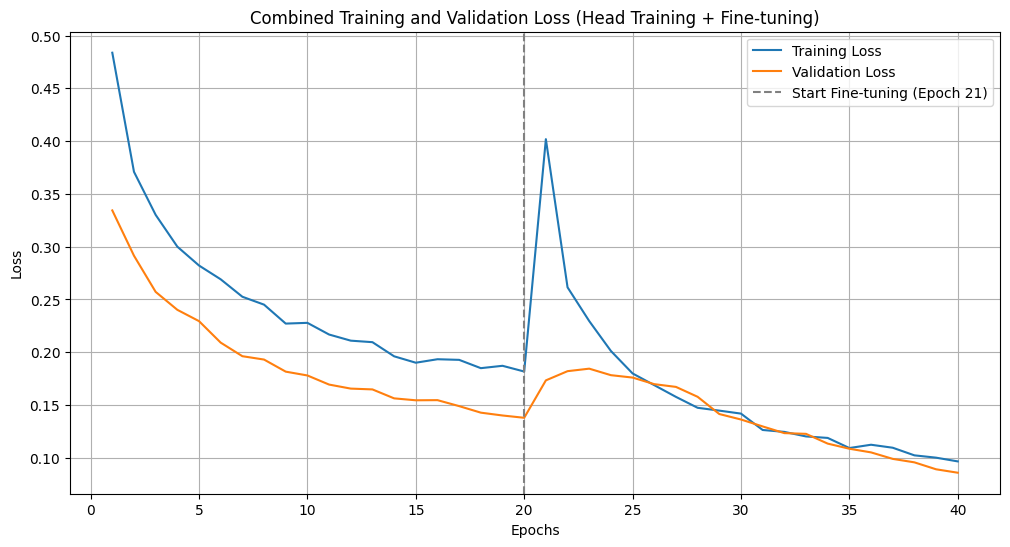

In [ ]:
import matplotlib.pyplot as plt

if 'history_head' in locals() and 'history_fine_tune' in locals():
    if (hasattr(history_head, 'history') and hasattr(history_fine_tune, 'history') and
        'loss' in history_head.history and 'val_loss' in history_head.history and
        'loss' in history_fine_tune.history and 'val_loss' in history_fine_tune.history):

        # Kết hợp history từ 2 giai đoạn
        acc = history_head.history['loss'] + history_fine_tune.history['loss']
        val_acc = history_head.history['val_loss'] + history_fine_tune.history['val_loss']

        total_epochs_ran = len(acc)
        epochs_range_combined = range(1, total_epochs_ran + 1)

        plt.figure(figsize=(12, 6))
        plt.plot(epochs_range_combined, acc, label='Training Loss')
        plt.plot(epochs_range_combined, val_acc, label='Validation Loss')

        # Đánh dấu điểm bắt đầu fine-tuning (tùy chọn)
        initial_epochs_ran = len(history_head.history['loss'])
        plt.axvline(x=initial_epochs_ran, color='grey', linestyle='--', label=f'Start Fine-tuning (Epoch {initial_epochs_ran+1})')

        plt.title('Combined Training and Validation Loss (Head Training + Fine-tuning)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right') # Điều chỉnh vị trí chú thích nếu cần
        plt.grid(True)
        plt.show()

    else:
         print("Một hoặc cả hai history objects (history_head, history_fine_tune) bị thiếu hoặc thiếu keys loss.")

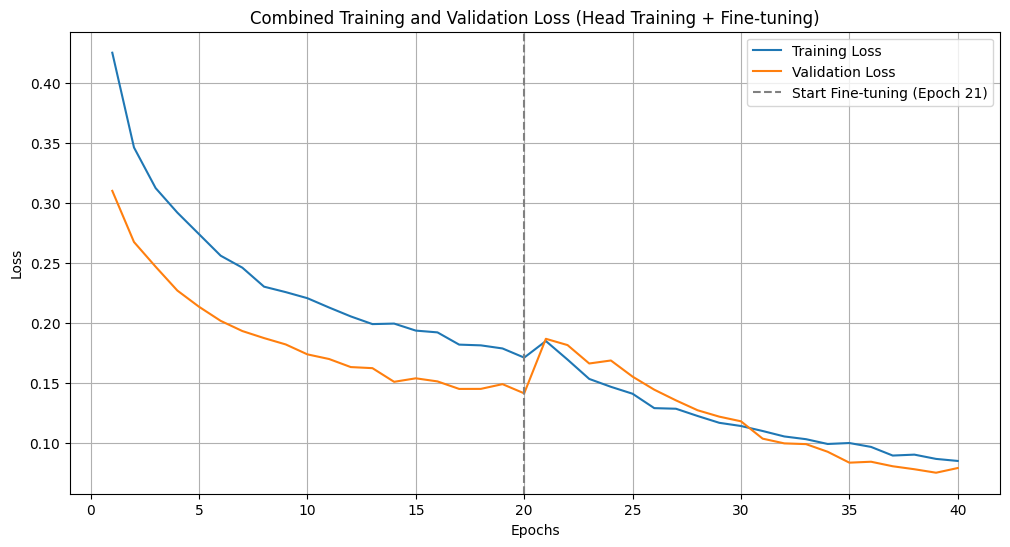

In [20]:
import matplotlib.pyplot as plt

if 'history_head' in locals() and 'history_fine_tune' in locals():
    if (hasattr(history_head, 'history') and hasattr(history_fine_tune, 'history') and
        'loss' in history_head.history and 'val_loss' in history_head.history and
        'loss' in history_fine_tune.history and 'val_loss' in history_fine_tune.history):

        # Kết hợp history từ 2 giai đoạn
        acc = history_head.history['loss'] + history_fine_tune.history['loss']
        val_acc = history_head.history['val_loss'] + history_fine_tune.history['val_loss']

        total_epochs_ran = len(acc)
        epochs_range_combined = range(1, total_epochs_ran + 1)

        plt.figure(figsize=(12, 6))
        plt.plot(epochs_range_combined, acc, label='Training Loss')
        plt.plot(epochs_range_combined, val_acc, label='Validation Loss')

        # Đánh dấu điểm bắt đầu fine-tuning (tùy chọn)
        initial_epochs_ran = len(history_head.history['loss'])
        plt.axvline(x=initial_epochs_ran, color='grey', linestyle='--', label=f'Start Fine-tuning (Epoch {initial_epochs_ran+1})')

        plt.title('Combined Training and Validation Loss (Head Training + Fine-tuning)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right') # Điều chỉnh vị trí chú thích nếu cần
        plt.grid(True)
        plt.show()

    else:
         print("Một hoặc cả hai history objects (history_head, history_fine_tune) bị thiếu hoặc thiếu keys loss.")

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import os
import pandas as pd
from sklearn.model_selection import train_test_split
# Giả định các biến sau đã tồn tại từ code trước của bạn:
# df, root_path, load_images_and_labels, train_datagen, val_datagen
# images, labels (kết quả từ load_images_and_labels)
# X_train, X_val, y_train, y_val (kết quả từ train_test_split)

# --- 1. Load Model ---
model_path = './new_models/mobilenetv2_model_final.h5' # Hoặc model_checkpoint.weights.h5 nếu chỉ lưu weights
print(f"Đang tải model từ: {model_path}")

if not os.path.exists(model_path):
    print(f"Lỗi: File model không tồn tại tại '{model_path}'")
    # Có thể thử load weights nếu file .h5 không có
    weights_path = './new_models/model_finetune_checkpoint.weights.h5' # Hoặc checkpoint phù hợp nhất
    if os.path.exists(weights_path):
        print(f"Thử tải weights từ: {weights_path}")
        raise FileNotFoundError(f"Model file {model_path} not found, and weight loading requires build_model().")
    else:
         raise FileNotFoundError(f"Neither model file {model_path} nor weights file {weights_path} found.")
else:
    try:
        model = load_model(model_path)
        print("Model đã được tải thành công.")
        # model.summary() # Kiểm tra nhanh cấu trúc model
    except Exception as e:
        print(f"Lỗi khi tải model: {e}")
        # Xử lý lỗi nếu cần
        exit() # Thoát nếu không load được model

# --- Định nghĩa nhãn ---
class_labels = ['natural', 'sleepy_eye', 'yawn', 'rub_eye', 'look_away']

# --- 2. Chuẩn bị Dữ liệu (Ví dụ cho tập Validation) ---
# Chỉ cần rescale, không cần augmentation cho việc dự đoán/đánh giá
print(f"Chuẩn bị dữ liệu validation (rescaling)...")
# Đảm bảo X_val là kiểu float trước khi chia
X_val_processed = X_val.astype('float32') / 255.0
y_val_true = y_val # Nhãn thật cho tập validation

print(f"Shape của X_val_processed: {X_val_processed.shape}")
print(f"Shape của y_val_true: {y_val_true.shape}")


# --- 3. Lấy Dự đoán ---
print("Lấy dự đoán trên tập validation...")
y_pred_proba = model.predict(X_val_processed)
print(f"Shape của y_pred_proba: {y_pred_proba.shape}")


# --- 4. Chuyển đổi Dự đoán thành Nhãn Binary ---
threshold = 0.5
print(f"Áp dụng ngưỡng threshold = {threshold}...")
y_pred_binary = (y_pred_proba >= threshold).astype(int)
print(f"Shape của y_pred_binary: {y_pred_binary.shape}")
# Xem thử vài dự đoán đầu tiên
print("Ví dụ dự đoán (xác suất):\n", y_pred_proba[:5])
print("Ví dụ dự đoán (binary sau threshold):\n", y_pred_binary[:5])
print("Ví dụ nhãn thật:\n", y_val_true[:5])


# --- 5. Tính và Vẽ Confusion Matrix cho từng Nhãn ---

def plot_multilabel_confusion_matrices(y_true, y_pred_binary, labels):
    """
    Vẽ confusion matrix 2x2 cho từng nhãn trong bài toán multi-label.

    Args:
        y_true (np.array): Mảng 2D chứa nhãn thật (n_samples, n_labels).
        y_pred_binary (np.array): Mảng 2D chứa nhãn dự đoán dạng binary (n_samples, n_labels).
        labels (list): Danh sách tên các nhãn.
    """
    n_labels = len(labels)
    # Sử dụng hàm multilabel_confusion_matrix của sklearn để tính tất cả cùng lúc
    mcm = multilabel_confusion_matrix(y_true, y_pred_binary)

    # Xác định bố cục subplot (ví dụ: 2 hàng)
    n_cols = 3 # Số cột mong muốn cho subplot
    n_rows = (n_labels + n_cols - 1) // n_cols # Tính số hàng cần thiết
    plt.figure(figsize=(n_cols * 5, n_rows * 5)) # Điều chỉnh kích thước tổng thể

    for i, label in enumerate(labels):
        cm = mcm[i] # Lấy ma trận 2x2 cho nhãn thứ i
        tn, fp, fn, tp = cm.ravel() # Lấy các giá trị TN, FP, FN, TP

        plt.subplot(n_rows, n_cols, i + 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[f'Not {label}', label],
                    yticklabels=[f'Not {label}', label],
                    annot_kws={"size": 12}) # Cỡ chữ annotation
        plt.title(f'Confusion Matrix for: {label}\nTN={tn}, FP={fp}, FN={fn}, TP={tp}', fontsize=12)
        plt.ylabel('True Label', fontsize=10)
        plt.xlabel('Predicted Label', fontsize=10)
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9)

    plt.tight_layout() # Tự động điều chỉnh khoảng cách subplot
    plt.show()

print("\n--- Vẽ Confusion Matrices cho tập Validation ---")
plot_multilabel_confusion_matrices(y_val_true, y_pred_binary, class_labels)

# --- (Tùy chọn) Vẽ cho tập Training ---
# Lặp lại các bước 2, 3, 4 cho tập training nếu muốn
# print("\n\n--- Vẽ Confusion Matrices cho tập Training ---")
# X_train_processed = X_train.astype('float32') / 255.0
# y_train_true = y_train
# y_train_pred_proba = model.predict(X_train_processed)
# y_train_pred_binary = (y_train_pred_proba >= threshold).astype(int)
# plot_multilabel_confusion_matrices(y_train_true, y_train_pred_binary, class_labels)

# --- (Tùy chọn) In Classification Report ---
# Cung cấp precision, recall, f1-score cho từng lớp và các giá trị trung bình
print("\n--- Classification Report (Validation Set) ---")
# Lưu ý: zero_division=0 để tránh cảnh báo khi một lớp không có mẫu nào (ít xảy ra nhưng có thể)
# target_names=class_labels để hiển thị tên lớp thay vì chỉ số
print(classification_report(y_val_true, y_pred_binary, target_names=class_labels, zero_division=0))

Đang tải model từ: ./new_models/mobilenetv2_model_final.h5
Model đã được tải thành công.
Chuẩn bị dữ liệu validation (rescaling)...


MemoryError: Unable to allocate 382. MiB for an array with shape (665, 224, 224, 3) and data type float32

In [ ]:
from sklearn.metrics import classification_report

print("\n--- Classification Report (Validation Set) ---")

# y_val_true: Nhãn thật (từ tập validation)
# y_pred_binary: Nhãn dự đoán sau khi áp dụng threshold (trên tập validation)
# target_names=class_labels: Hiển thị tên của các lớp thay vì chỉ số 0, 1, 2,...
# zero_division=0: Xử lý trường hợp chia cho 0 (ví dụ: khi không có dự đoán nào cho một lớp)
#                  bằng cách đặt kết quả thành 0 thay vì báo lỗi/warning.
#                  Bạn có thể dùng 'warn' nếu muốn thấy cảnh báo.
report = classification_report(
    y_val_true,
    y_pred_binary,
    target_names=class_labels,
    zero_division=0
)

print(report)

# --- (Tùy chọn) Tính toán và in riêng lẻ từng chỉ số nếu muốn ---
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print("\n--- Individual Metrics per Label (Validation Set) ---")
print(f"{'Label':<12} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Accuracy':<10}")
print("-" * 65)

# Tính accuracy tổng thể (exact match ratio - tỷ lệ dự đoán đúng *tất cả* các nhãn cho một mẫu)
# Lưu ý: Đây thường là một chỉ số rất khắt khe cho multi-label
subset_accuracy = accuracy_score(y_val_true, y_pred_binary)
print(f"Subset Accuracy (Exact Match Ratio): {subset_accuracy:.4f}\n")


for i, label in enumerate(class_labels):
    # Lấy cột tương ứng cho nhãn hiện tại
    true_col = y_val_true[:, i]
    pred_col = y_pred_binary[:, i]

    # Tính toán từng chỉ số cho nhãn này
    precision = precision_score(true_col, pred_col, zero_division=0)
    recall = recall_score(true_col, pred_col, zero_division=0)
    f1 = f1_score(true_col, pred_col, zero_division=0)
    # Accuracy cho từng nhãn (tỷ lệ dự đoán đúng cho nhãn đó, bất kể các nhãn khác)
    label_accuracy = accuracy_score(true_col, pred_col)


    print(f"{label:<12} | {precision:<10.4f} | {recall:<10.4f} | {f1:<10.4f} | {label_accuracy:<10.4f}")

print("-" * 65)

# Tính các giá trị trung bình (như trong classification_report)
precision_micro = precision_score(y_val_true, y_pred_binary, average='micro', zero_division=0)
recall_micro = recall_score(y_val_true, y_pred_binary, average='micro', zero_division=0)
f1_micro = f1_score(y_val_true, y_pred_binary, average='micro', zero_division=0)

precision_macro = precision_score(y_val_true, y_pred_binary, average='macro', zero_division=0)
recall_macro = recall_score(y_val_true, y_pred_binary, average='macro', zero_division=0)
f1_macro = f1_score(y_val_true, y_pred_binary, average='macro', zero_division=0)

precision_weighted = precision_score(y_val_true, y_pred_binary, average='weighted', zero_division=0)
recall_weighted = recall_score(y_val_true, y_pred_binary, average='weighted', zero_division=0)
f1_weighted = f1_score(y_val_true, y_pred_binary, average='weighted', zero_division=0)

print("\n--- Average Metrics ---")
print(f"{'Average Type':<12} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
print("-" * 50)
print(f"{'Micro':<12} | {precision_micro:<10.4f} | {recall_micro:<10.4f} | {f1_micro:<10.4f}")
print(f"{'Macro':<12} | {precision_macro:<10.4f} | {recall_macro:<10.4f} | {f1_macro:<10.4f}")
print(f"{'Weighted':<12} | {precision_weighted:<10.4f} | {recall_weighted:<10.4f} | {f1_weighted:<10.4f}")


--- Classification Report (Validation Set) ---
              precision    recall  f1-score   support

     natural       0.89      0.97      0.93       200
  sleepy_eye       0.99      0.87      0.93       228
        yawn       0.97      0.96      0.97        76
     rub_eye       1.00      0.93      0.96        41
   look_away       0.94      0.91      0.92       165

   micro avg       0.95      0.92      0.93       710
   macro avg       0.96      0.93      0.94       710
weighted avg       0.95      0.92      0.93       710
 samples avg       0.93      0.93      0.92       710


--- Individual Metrics per Label (Validation Set) ---
Label        | Precision  | Recall     | F1-Score   | Accuracy  
-----------------------------------------------------------------
Subset Accuracy (Exact Match Ratio): 0.9038

natural      | 0.8864     | 0.9750     | 0.9286     | 0.9549    
sleepy_eye   | 0.9950     | 0.8684     | 0.9274     | 0.9534    
yawn         | 0.9733     | 0.9605     | 0.9669 

###Save and Load the Model

In [ ]:
model.save('sleepiness_detection_model.h5')

### Test model

In [4]:
%pip install protobuf==3.20.*


   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/904.0 kB ? eta -:--:--
   ---------------------------------------- 904.0/904.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [1]:
import numpy as np
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os

In [2]:
import tensorflow as tf

tf.__version__

'2.19.0'

In [23]:
# Make sure the correct model is loaded
# from tensorflow.keras.models import load_model
# model = load_model('sleepiness_detection_model_final.h5') # Load the FINE-TUNED model

def build_model(input_shape=(224, 224, 3), num_classes=5):
    # Load pre-trained base model (không bao gồm lớp fully connected cuối)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Đóng băng các lớp của base model (để không huấn luyện lại chúng ban đầu)
    base_model.trainable = False # Quan trọng!

    x = base_model.output
    x = GlobalAveragePooling2D()(x) # Giảm chiều dữ liệu
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x) # Sử dụng sigmoid cho multi-label

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def predict_multi_label(image_path, model, threshold=0.5): # Pass model as argument
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None, None

    image = cv2.resize(image, (224, 224))  # Resize image to 224x224
    image = image / 255.0  # Normalize the image (match training)
    image = image.astype(np.float32) # Ensure float32 dtype

    image = np.expand_dims(image, axis=0)  # Add batch dimension

    predictions = model.predict(image)[0] # Get the prediction for the single image

    # Define the class labels
    class_labels = ['natural', 'sleepy_eye', 'yawn', 'rub_eye', 'look_away']

    print("--- Predicted Probabilities ---")
    predicted_labels = []
    confidences = {}
    for i, label in enumerate(class_labels):
        confidence = predictions[i]
        confidences[label] = confidence
        print(f"{label}: {confidence:.4f}")
        if confidence >= threshold:
            predicted_labels.append(label)

    # If no label meets the threshold, maybe report the one with highest confidence? (Optional)
    if not predicted_labels:
         highest_confidence_idx = np.argmax(predictions)
         print(f"\nNote: No label reached threshold {threshold}.")
         print(f"Highest confidence label: {class_labels[highest_confidence_idx]} ({predictions[highest_confidence_idx]:.4f})")

    return predicted_labels, confidences # Return list of active labels and all confidences

# --- Example Usage ---
# Make sure you load the *final, best* model first
try:
    # Try loading the fine-tuned model first if it exists
    model_path = './model/mobilenet-v2.h5'
    if not os.path.exists(model_path):
         # Fallback to the potentially non-finetuned one if needed
        model_path = './model/mobilenet-v2.h5'
        if not os.path.exists(model_path):
            # Fallback to loading weights if full model save failed or wasn't run
            model_path = './model/mobilenet-v2_finetune_checkpoint.weights.h5' # Or model_head_checkpoint...
            print(f"Loading weights from: {model_path}")
            # Need to rebuild the model structure if loading only weights
            model = build_model()
            model.load_weights(model_path)
        else:
            print(f"Loading full model from: {model_path}")
            model = load_model(model_path)
    else:
        print(f"Loading full model from: {model_path}")
        model = load_model(model_path)

    # model.summary() # Verify loaded model

    image_path_test = 'image.png' # Change as needed
    predicted_labels, confidences = predict_multi_label(image_path_test, model, threshold=0.5)

    if predicted_labels is not None:
        print(f"\nPredicted active labels (threshold 0.5): {predicted_labels}")

except Exception as e:
    print(f"Error during model loading or prediction: {e}")
    print("Please ensure the model file exists and training completed successfully.")

Loading full model from: ./model/mobilenet-v2.h5
Error during model loading or prediction: Unrecognized keyword arguments: ['batch_shape']
Please ensure the model file exists and training completed successfully.
